In [2]:
import credentials as cr
import SQL_requests as rq
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from spotify_api import Spotify_api
from db_connect import Db_connect
from recommendation_system import Recommendation

%load_ext autoreload
%autoreload 2

## Application parameters

In [3]:
# redirect_uri = 'http://localhost/'
data_path = cr.DATA_PATH

sp = Spotify_api()
db = Db_connect()
rc = Recommendation()

## Get datas using Spotify API  
I get my personnal spotify datas using spotify api and spotify_api.py class. The Pandas dataframes created are converted into csv files which will be used to create the sqlite database.

In [189]:
playlists_df = sp.get_playlists_with_tracks()

features_df = sp.get_playlist_features(playlists_df)
features_df.drop_duplicates(inplace=True)

tracks_df = sp.get_tracks(features_df)

contains_df = sp.get_contains(playlists_df)

playlists_df.to_csv(data_path + 'playlists.csv', encoding='utf-8')
features_df.to_csv(data_path + 'features.csv', encoding='utf-8')
tracks_df.to_csv(data_path + 'tracks.csv', encoding='utf-8')
contains_df.to_csv(data_path + 'contains.csv', encoding='utf-8', index=False)

Found playlists :  28


## DataBase connect and creation

Create the SQLite database, create or update the tables with spotify datas (playlist, feature, track).

In [13]:
db.init_connection()
db.create_tables([rq.CREATE_PLAYLIST, rq.CREATE_TRACK, rq.CREATE_TRACK_FEATURES, rq.CREATE_CONTAINS])
db.insert_data(rq.INSERT_PLAYLISTS, data_path + 'playlists.csv')
db.insert_data(rq.INSERT_TRACKS_FEATURES, data_path + 'features.csv')
db.insert_data(rq.INSERT_TRACKS, data_path + 'tracks.csv')
db.insert_data(rq.INSERT_CONTAINS, data_path + 'contains.csv')
db.close_connection()

## Developping the algorithm

I start by getting the 'Top 30' (6AsIwsN6mH7dQSChLsqSlY) playlist from the database, which will be used to developp and test the algorithm.  
Let's get the first try and view the results.

In [6]:
db.init_connection()
top_30_titles = pd.read_sql_query(rq.SELECT_PLAYLIST_TITLES + "'6AsIwsN6mH7dQSChLsqSlY'", db.connector).set_index('id')
track_titles = pd.read_sql_query(rq.SELECT_TRACKS_TITLES, db.connector).set_index('id')
track_features = pd.read_sql_query(rq.SELECT_TRACKS_FEATURES, db.connector).set_index('id')
db.close_connection()

### Vizualisation of the targetted playlist :

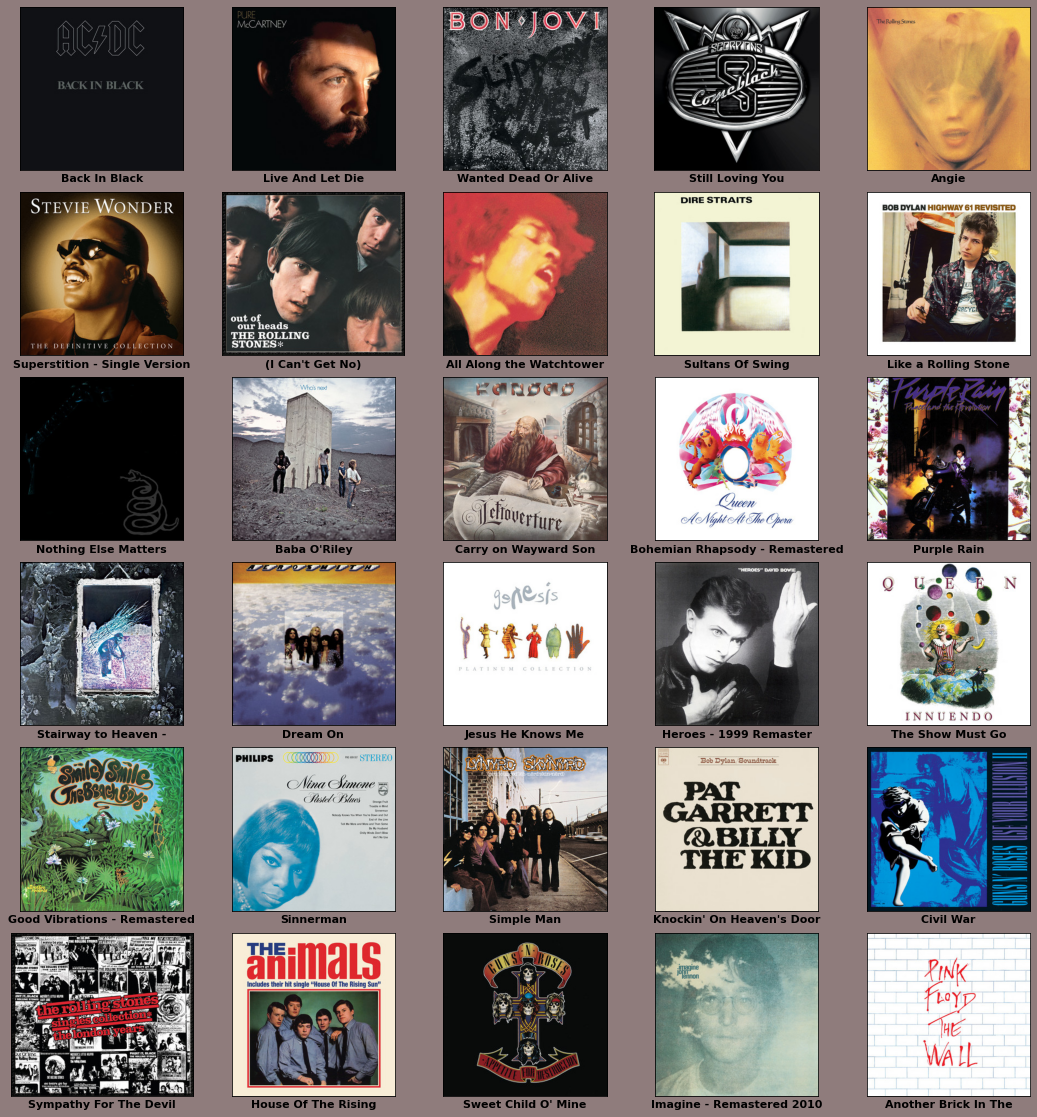

In [5]:
rc.visualize_cover(top_30_titles)

### FIrst model using nearest neighbors

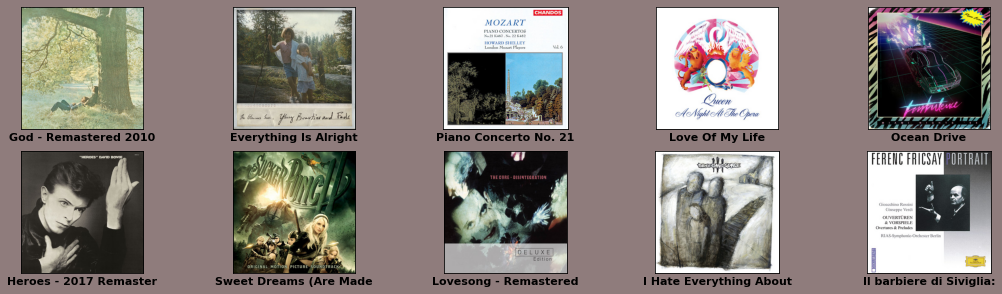

distance  weight  \
key                                           
7kipZd4tWx6Mu8kBgB2Z2r    16.096700       2   
42lrhaZzqJqCYHlfQTGozP    94.306253       2   
2YarjDYjBJuH63dUIh9OWv    99.611962       2   
2BlNyI35idBaI6BN6WGZeQ   120.282069       2   
02gySWUFk5JT4gMguGAhdO   653.076659       2   
7Jh1bpe76CNTCgdgAdBw4Z  1040.000226       2   
4kbuEwGf2koTfgZRxLDDKi  1480.473136       2   
2mIrfke7vosXAEWfz6ucyo  2134.828732       2   
4yRRrMzaXzXiCbbWrt5KDy  2187.059225       2   
0NEvOvhsDhXXG5tZM6sI98  4494.043153       2   

                                                                     name  \
key                                                                         
7kipZd4tWx6Mu8kBgB2Z2r                              God - Remastered 2010   
42lrhaZzqJqCYHlfQTGozP                              Everything Is Alright   
2YarjDYjBJuH63dUIh9OWv  Piano Concerto No. 21 in C Major, K. 467 "Elvi...   
2BlNyI35idBaI6BN6WGZeQ                  Love Of My Life - Remastered 2011   
02gySWUFk5JT4gMguGAhdO                                        Ocean Drive   
7Jh1bpe76CNTCgdgAdBw4Z                             Heroes - 2017 Remaster   
4kbuEwGf2koTfgZRxLDDKi                    Sweet Dreams (Are Made of This)   
2mIrfke7vosXAEWfz6ucyo                              Lovesong - Remastered   
4yRRrMzaXzXiCbbWrt5KDy  I Hate Everything About You - Live Acoustic - ...   
0NEvOvhsDhXXG5tZM6sI98       Il barbiere di Siviglia: Overture (Sinfonia)   

                                                                album_img  
key                                                                        
7kipZd4tWx6Mu8kBgB2Z2r  https://i.scdn.co/image/ab67616d00001e02646216...  
42lrhaZzqJqCYHlfQTGozP  https://i.scdn.co/image/ab67616d00001e02a3d221...  
2YarjDYjBJuH63dUIh9OWv  https://i.scdn.co/image/ab67616d00001e020bb746...  
2BlNyI35idBaI6BN6WGZeQ  https://i.scdn.co/image/ab67616d00001e02e319ba...  
02gySWUFk5JT4gMguGAhdO  https://i.scdn.co/image/ab67616d00001e02674dce...  
7Jh1bpe76CNTCgdgAdBw4Z  https://i.scdn.co/image/ab67616d00001e02bc1c63...  
4kbuEwGf2koTfgZRxLDDKi  https://i.scdn.co/image/ab67616d00001e02a98d7c...  
2mIrfke7vosXAEWfz6ucyo  https://i.scdn.co/image/ab67616d00001e02ee8b60...  
4yRRrMzaXzXiCbbWrt5KDy  https://i.scdn.co/image/ab67616d00001e02d3f7fc...  
0NEvOvhsDhXXG5tZM6sI98  https://i.scdn.co/image/ab67616d00001e02315090...

In [32]:
playlist, nonplaylist = rc.generate_playlist_nonplaylist(track_features, top_30_titles)
recommendation, recommendation_features = rc.get_recommendations(playlist, nonplaylist, track_features, track_titles)
rc.visualize_cover(recommendation)
display(recommendation)

##### Same model with data processing

danceability    energy  loudness  speechiness  \
id                                                                      
3tyTt5pEWblt96j1HsXiV5      0.000030  0.000030       0.0     0.000028   
0HEmnAUT8PHznIAAmVXqFJ      0.000067  0.000065       0.0     0.000063   
0DJnqFhVWoTDs58JPem5Zh      0.000030  0.000031       0.0     0.000027   
5MWKU5MnIuv5uQez4n0byz      0.000038  0.000037       0.0     0.000034   
029NqmIySn1kOY305AAhxT      0.000019  0.000019       0.0     0.000017   

                        acousticness  instrumentalness  liveness   valence  \
id                                                                           
3tyTt5pEWblt96j1HsXiV5      0.000028          0.000028  0.000028  0.000030   
0HEmnAUT8PHznIAAmVXqFJ      0.000062          0.000062  0.000062  0.000065   
0DJnqFhVWoTDs58JPem5Zh      0.000027          0.000027  0.000028  0.000030   
5MWKU5MnIuv5uQez4n0byz      0.000035          0.000036  0.000034  0.000037   
029NqmIySn1kOY305AAhxT      0.000017          0.000017  0.000017  0.000018   

                           tempo  duration_ms  ...  key_7  key_8  key_9  \
id                                             ...                        
3tyTt5pEWblt96j1HsXiV5  0.000262          1.0  ...      0      0      0   
0HEmnAUT8PHznIAAmVXqFJ  0.000558          1.0  ...      0      0      0   
0DJnqFhVWoTDs58JPem5Zh  0.000493          1.0  ...      0      0      0   
5MWKU5MnIuv5uQez4n0byz  0.000490          1.0  ...      0      0      0   
029NqmIySn1kOY305AAhxT  0.000324          1.0  ...      0      0      0   

                        key_10  key_11  time_signature_0  time_signature_1  \
id                                                                           
3tyTt5pEWblt96j1HsXiV5       0       0                 0                 0   
0HEmnAUT8PHznIAAmVXqFJ       0       1                 0                 0   
0DJnqFhVWoTDs58JPem5Zh       0       0                 0                 0   
5MWKU5MnIuv5uQez4n0byz       0       0                 0                 0   
029NqmIySn1kOY305AAhxT       0       0                 0                 0   

                        time_signature_3  time_signature_4  time_signature_5  
id                                                                            
3tyTt5pEWblt96j1HsXiV5                 0                 1                 0  
0HEmnAUT8PHznIAAmVXqFJ                 0                 1                 0  
0DJnqFhVWoTDs58JPem5Zh                 0                 1                 0  
5MWKU5MnIuv5uQez4n0byz                 0                 1                 0  
029NqmIySn1kOY305AAhxT                 0                 1                 0  

[5 rows x 29 columns]

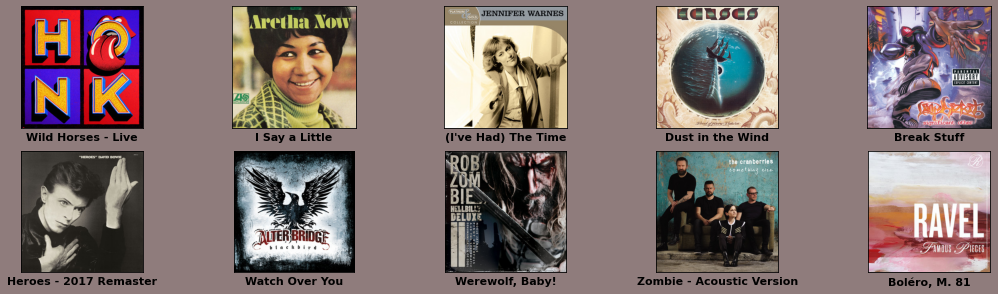

distance  weight  \
key                                        
4qWfbU8r7N87Enp19oMF62  0.000008       2   
3NfxSdJnVdon1axzloJgba  0.000011       2   
4BFMQ15vXr626UOoZL8bUI  0.000026       2   
6zeE5tKyr8Nu882DQhhSQI  0.000029       2   
5cZqsjVs6MevCnAkasbEOX  0.000002       1   
7Jh1bpe76CNTCgdgAdBw4Z  0.000005       1   
7kxfWvj6u9oWQ5C36kMtGb  0.000006       1   
7fv6wqJX3Mnu7z1dj7i0Ca  0.000007       1   
1qylvO4iCIZZcqc4TqSjTZ  0.000007       1   
0CDNVJ4YiK3XSi9JzUfZRD  0.000007       1   

                                                                     name  \
key                                                                         
4qWfbU8r7N87Enp19oMF62               Wild Horses - Live At London Stadium   
3NfxSdJnVdon1axzloJgba                              I Say a Little Prayer   
4BFMQ15vXr626UOoZL8bUI  (I've Had) The Time of My Life - From "Dirty D...   
6zeE5tKyr8Nu882DQhhSQI                                   Dust in the Wind   
5cZqsjVs6MevCnAkasbEOX                                        Break Stuff   
7Jh1bpe76CNTCgdgAdBw4Z                             Heroes - 2017 Remaster   
7kxfWvj6u9oWQ5C36kMtGb                                     Watch Over You   
7fv6wqJX3Mnu7z1dj7i0Ca                                    Werewolf, Baby!   
1qylvO4iCIZZcqc4TqSjTZ                          Zombie - Acoustic Version   
0CDNVJ4YiK3XSi9JzUfZRD                                      Boléro, M. 81   

                                                                album_img  
key                                                                        
4qWfbU8r7N87Enp19oMF62  https://i.scdn.co/image/ab67616d00001e02b027df...  
3NfxSdJnVdon1axzloJgba  https://i.scdn.co/image/ab67616d00001e0246c31f...  
4BFMQ15vXr626UOoZL8bUI  https://i.scdn.co/image/ab67616d00001e02927530...  
6zeE5tKyr8Nu882DQhhSQI  https://i.scdn.co/image/ab67616d00001e0259f0f5...  
5cZqsjVs6MevCnAkasbEOX  https://i.scdn.co/image/ab67616d00001e02378378...  
7Jh1bpe76CNTCgdgAdBw4Z  https://i.scdn.co/image/ab67616d00001e02bc1c63...  
7kxfWvj6u9oWQ5C36kMtGb  https://i.scdn.co/image/ab67616d00001e0233fe38...  
7fv6wqJX3Mnu7z1dj7i0Ca  https://i.scdn.co/image/ab67616d00001e02985d72...  
1qylvO4iCIZZcqc4TqSjTZ  https://i.scdn.co/image/ab67616d00001e02d28b05...  
0CDNVJ4YiK3XSi9JzUfZRD  https://i.scdn.co/image/ab67616d00001e027c21fe...

In [25]:
track_features_processed = rc.process_data(track_features)
display(track_features_processed.head())

playlist, nonplaylist = rc.generate_playlist_nonplaylist(track_features_processed, top_30_titles)
playlist_sum = playlist.sum(axis = 0)

recommendation, recommendation_features = rc.get_recommendations_processed(playlist, nonplaylist, track_features_processed, track_titles)

rc.visualize_cover(recommendation)

display(recommendation)


In [26]:
cosine = rc.get_cosine_similarity(playlist, recommendation_features, track_titles)
display(cosine)
print("MEAN COSINE SIMILARITY : ", cosine.sim_mean.mean())

sim  \
id                                                                          
4qWfbU8r7N87Enp19oMF62  [[0.7500000041747896, 0.7500000063486101, 0.75...   
3NfxSdJnVdon1axzloJgba  [[0.749999991017485, 0.7500000068345505, 0.750...   
4BFMQ15vXr626UOoZL8bUI  [[0.5000000107325927, 0.5000000196590754, 0.50...   
6zeE5tKyr8Nu882DQhhSQI  [[0.750000000534806, 0.7500000101413444, 0.750...   
5cZqsjVs6MevCnAkasbEOX  [[0.7499999908279482, 0.9999999873477543, 0.99...   
7Jh1bpe76CNTCgdgAdBw4Z  [[0.7500000042598679, 0.7500000073841926, 0.75...   
7kxfWvj6u9oWQ5C36kMtGb  [[0.7499999914755284, 0.7500000079370628, 0.75...   
7fv6wqJX3Mnu7z1dj7i0Ca  [[0.7500000002856415, 0.7500000108025013, 0.75...   
1qylvO4iCIZZcqc4TqSjTZ  [[0.5000000105245387, 0.500000018552516, 0.500...   
0CDNVJ4YiK3XSi9JzUfZRD  [[0.5000000053433642, 0.5000000059565932, 0.50...   

                        sim_mean  \
id                                 
4qWfbU8r7N87Enp19oMF62  0.691667   
3NfxSdJnVdon1axzloJgba  0.691667   
4BFMQ15vXr626UOoZL8bUI  0.583333   
6zeE5tKyr8Nu882DQhhSQI  0.691667   
5cZqsjVs6MevCnAkasbEOX  0.675000   
7Jh1bpe76CNTCgdgAdBw4Z  0.691667   
7kxfWvj6u9oWQ5C36kMtGb  0.691667   
7fv6wqJX3Mnu7z1dj7i0Ca  0.691667   
1qylvO4iCIZZcqc4TqSjTZ  0.575000   
0CDNVJ4YiK3XSi9JzUfZRD  0.466667   

                                                                     name  \
id                                                                          
4qWfbU8r7N87Enp19oMF62               Wild Horses - Live At London Stadium   
3NfxSdJnVdon1axzloJgba                              I Say a Little Prayer   
4BFMQ15vXr626UOoZL8bUI  (I've Had) The Time of My Life - From "Dirty D...   
6zeE5tKyr8Nu882DQhhSQI                                   Dust in the Wind   
5cZqsjVs6MevCnAkasbEOX                                        Break Stuff   
7Jh1bpe76CNTCgdgAdBw4Z                             Heroes - 2017 Remaster   
7kxfWvj6u9oWQ5C36kMtGb                                     Watch Over You   
7fv6wqJX3Mnu7z1dj7i0Ca                                    Werewolf, Baby!   
1qylvO4iCIZZcqc4TqSjTZ                          Zombie - Acoustic Version   
0CDNVJ4YiK3XSi9JzUfZRD                                      Boléro, M. 81   

                                                                album_img  
id                                                                         
4qWfbU8r7N87Enp19oMF62  https://i.scdn.co/image/ab67616d00001e02b027df...  
3NfxSdJnVdon1axzloJgba  https://i.scdn.co/image/ab67616d00001e0246c31f...  
4BFMQ15vXr626UOoZL8bUI  https://i.scdn.co/image/ab67616d00001e02927530...  
6zeE5tKyr8Nu882DQhhSQI  https://i.scdn.co/image/ab67616d00001e0259f0f5...  
5cZqsjVs6MevCnAkasbEOX  https://i.scdn.co/image/ab67616d00001e02378378...  
7Jh1bpe76CNTCgdgAdBw4Z  https://i.scdn.co/image/ab67616d00001e02bc1c63...  
7kxfWvj6u9oWQ5C36kMtGb  https://i.scdn.co/image/ab67616d00001e0233fe38...  
7fv6wqJX3Mnu7z1dj7i0Ca  https://i.scdn.co/image/ab67616d00001e02985d72...  
1qylvO4iCIZZcqc4TqSjTZ  https://i.scdn.co/image/ab67616d00001e02d28b05...  
0CDNVJ4YiK3XSi9JzUfZRD  https://i.scdn.co/image/ab67616d00001e027c21fe...

MEAN COSINE SIMILARITY :  0.6450000119082111


##### RandomizedSearchCV // GridSearch

### Second model using cosine similarity

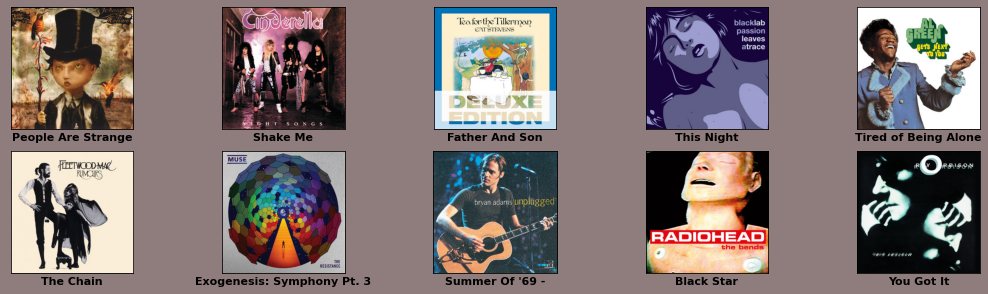

danceability    energy  loudness  speechiness  \
id                                                                      
6YAqup47jDR6QDYgILHlVX      0.000052  0.000052       0.0     0.000049   
1Qjpl8Kav6rrO92ZuG0OK8      0.000056  0.000057       0.0     0.000054   
2tbdjsdJ9xtyunKnZBkGxF      0.000054  0.000054       0.0     0.000052   
39zkdU2RwrLdgitEEOrGcZ      0.000040  0.000039       0.0     0.000037   
10vkYRKw6Jjr7try1ir50G      0.000054  0.000052       0.0     0.000050   

                        acousticness  instrumentalness  liveness   valence  \
id                                                                           
6YAqup47jDR6QDYgILHlVX      0.000053          0.000050  0.000049  0.000051   
1Qjpl8Kav6rrO92ZuG0OK8      0.000053          0.000053  0.000054  0.000056   
2tbdjsdJ9xtyunKnZBkGxF      0.000055          0.000052  0.000052  0.000054   
39zkdU2RwrLdgitEEOrGcZ      0.000037          0.000038  0.000037  0.000039   
10vkYRKw6Jjr7try1ir50G      0.000052          0.000050  0.000050  0.000053   

                           tempo  duration_ms  ...  key_10  key_11  \
id                                             ...                   
6YAqup47jDR6QDYgILHlVX  0.000649          1.0  ...       0       0   
1Qjpl8Kav6rrO92ZuG0OK8  0.000650          1.0  ...       0       0   
2tbdjsdJ9xtyunKnZBkGxF  0.000668          1.0  ...       0       0   
39zkdU2RwrLdgitEEOrGcZ  0.000667          1.0  ...       0       0   
10vkYRKw6Jjr7try1ir50G  0.000618          1.0  ...       0       0   

                        time_signature_0  time_signature_1  time_signature_3  \
id                                                                             
6YAqup47jDR6QDYgILHlVX                 0                 0                 0   
1Qjpl8Kav6rrO92ZuG0OK8                 0                 0                 0   
2tbdjsdJ9xtyunKnZBkGxF                 0                 0                 0   
39zkdU2RwrLdgitEEOrGcZ                 0                 0                 0   
10vkYRKw6Jjr7try1ir50G                 0                 0                 0   

                        time_signature_4  time_signature_5       sim  \
id                                                                     
6YAqup47jDR6QDYgILHlVX                 1                 0  0.867222   
1Qjpl8Kav6rrO92ZuG0OK8                 1                 0  0.867222   
2tbdjsdJ9xtyunKnZBkGxF                 1                 0  0.867222   
39zkdU2RwrLdgitEEOrGcZ                 1                 0  0.867222   
10vkYRKw6Jjr7try1ir50G                 1                 0  0.867222   

                                        name  \
id                                             
6YAqup47jDR6QDYgILHlVX    People Are Strange   
1Qjpl8Kav6rrO92ZuG0OK8              Shake Me   
2tbdjsdJ9xtyunKnZBkGxF        Father And Son   
39zkdU2RwrLdgitEEOrGcZ            This Night   
10vkYRKw6Jjr7try1ir50G  Tired of Being Alone   

                                                                album_img  
id                                                                         
6YAqup47jDR6QDYgILHlVX  https://i.scdn.co/image/ab67616d00001e02215dfd...  
1Qjpl8Kav6rrO92ZuG0OK8  https://i.scdn.co/image/ab67616d00001e028e5911...  
2tbdjsdJ9xtyunKnZBkGxF  https://i.scdn.co/image/ab67616d00001e024a45ab...  
39zkdU2RwrLdgitEEOrGcZ  https://i.scdn.co/image/ab67616d00001e026a417f...  
10vkYRKw6Jjr7try1ir50G  https://i.scdn.co/image/ab67616d00001e02fec6bb...  

[5 rows x 32 columns]

In [185]:
from sklearn.metrics.pairwise import cosine_similarity

track_features_processed = rc.process_data(track_features)

playlist, nonplaylist = rc.generate_playlist_nonplaylist(track_features_processed, top_30_titles)
playlist_sum = playlist.sum(axis = 0)

nonplaylist_copy = nonplaylist.copy()

nonplaylist_copy['sim'] = cosine_similarity(nonplaylist.values, playlist_sum.values.reshape(1, -1))[:,0]

recommendation = nonplaylist_copy.sort_values('sim',ascending = False).head(10)
recommendation = recommendation.merge(track_titles, left_index=True, right_index=True)

rc.visualize_cover(recommendation)

recommendation.head()

### Third model using classification

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

track_features_processed = rc.process_data(track_features)
playlist, nonplaylist = rc.generate_playlist_nonplaylist(track_features_processed, top_30_titles)

train_test_dataset = track_features_processed.copy()
train_test_dataset['playlist'] = train_test_dataset.apply(lambda x: int(x.name in top_30_titles.index), axis=1) # Generate 1 in playlist 0 out playlist

classifier_data = train_test_dataset.copy()
classifier_data = classifier_data.sort_values(['playlist'], ascending=False).head(100)

classifier_target = classifier_data['playlist']

classifier_data = classifier_data.drop('loudness',axis = 1)
classifier_data = classifier_data.drop('playlist',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(classifier_data, classifier_target, test_size=0.3, random_state=42)

##### kNNClassifier

In [10]:
knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7333333333333333


C:\Users\audre\anaconda3\envs\spotify2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\audre\anaconda3\envs\spotify2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\audre\anaconda3\envs\spotify2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\audre\anaconda3\envs\spotify2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\audre\anaconda3\envs\spotify2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


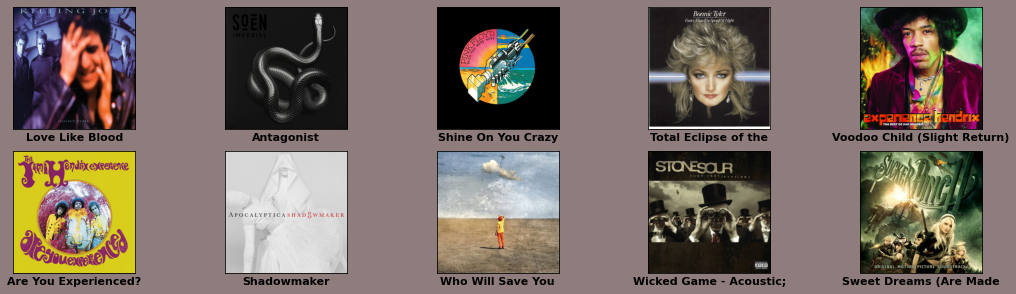

danceability    energy  speechiness  acousticness  \
id                                                                          
14z3RzUHeZQgtpOlSYvmZD      0.000021  0.000022     0.000020      0.000020   
4G44da3BuHq3IBEAv9fyuP      0.000013  0.000014     0.000011      0.000011   
2dWCp5vcNwSy25zRVFGC5t      0.000015  0.000015     0.000015      0.000016   
1VrfLrBviw9A6JzRoo3t2C      0.000032  0.000032     0.000031      0.000032   
6d3I7THB2bONUkxOo1DvmZ      0.000022  0.000024     0.000022      0.000023   
02POyqtbrdmYQ3RxsTrYMD      0.000028  0.000029     0.000027      0.000026   
5E0uG43qPLcPKk3mu53VPR      0.000011  0.000012     0.000010      0.000010   
2Qb7LQYOECnFqWGKAQl6eJ      0.000029  0.000029     0.000028      0.000029   
3V1H6liHwCDcWeqdPJabOM      0.000037  0.000036     0.000035      0.000037   
4kbuEwGf2koTfgZRxLDDKi      0.000034  0.000035     0.000033      0.000033   

                        instrumentalness  liveness   valence     tempo  \
id                                                                       
14z3RzUHeZQgtpOlSYvmZD          0.000022  0.000021  0.000022  0.000328   
4G44da3BuHq3IBEAv9fyuP          0.000011  0.000012  0.000012  0.000309   
2dWCp5vcNwSy25zRVFGC5t          0.000016  0.000015  0.000015  0.000185   
1VrfLrBviw9A6JzRoo3t2C          0.000031  0.000031  0.000031  0.000345   
6d3I7THB2bONUkxOo1DvmZ          0.000021  0.000021  0.000023  0.000302   
02POyqtbrdmYQ3RxsTrYMD          0.000026  0.000027  0.000028  0.000350   
5E0uG43qPLcPKk3mu53VPR          0.000010  0.000010  0.000011  0.000287   
2Qb7LQYOECnFqWGKAQl6eJ          0.000028  0.000028  0.000028  0.000378   
3V1H6liHwCDcWeqdPJabOM          0.000035  0.000037  0.000036  0.000444   
4kbuEwGf2koTfgZRxLDDKi          0.000034  0.000034  0.000034  0.000324   

                        duration_ms  mode_0  ...  key_11  time_signature_0  \
id                                           ...                             
14z3RzUHeZQgtpOlSYvmZD          1.0       1  ...       0                 0   
4G44da3BuHq3IBEAv9fyuP          1.0       1  ...       0                 0   
2dWCp5vcNwSy25zRVFGC5t          1.0       1  ...       0                 0   
1VrfLrBviw9A6JzRoo3t2C          1.0       0  ...       0                 0   
6d3I7THB2bONUkxOo1DvmZ          1.0       0  ...       0                 0   
02POyqtbrdmYQ3RxsTrYMD          1.0       0  ...       0                 0   
5E0uG43qPLcPKk3mu53VPR          1.0       0  ...       0                 0   
2Qb7LQYOECnFqWGKAQl6eJ          1.0       1  ...       0                 0   
3V1H6liHwCDcWeqdPJabOM          1.0       0  ...       0                 0   
4kbuEwGf2koTfgZRxLDDKi          1.0       0  ...       0                 0   

                        time_signature_1  time_signature_3  time_signature_4  \
id                                                                             
14z3RzUHeZQgtpOlSYvmZD                 0                 0                 1   
4G44da3BuHq3IBEAv9fyuP                 0                 0                 1   
2dWCp5vcNwSy25zRVFGC5t                 0                 1                 0   
1VrfLrBviw9A6JzRoo3t2C                 0                 0                 1   
6d3I7THB2bONUkxOo1DvmZ                 0                 0                 1   
02POyqtbrdmYQ3RxsTrYMD                 0                 0                 1   
5E0uG43qPLcPKk3mu53VPR                 0                 0                 1   
2Qb7LQYOECnFqWGKAQl6eJ                 0                 1                 0   
3V1H6liHwCDcWeqdPJabOM                 0                 0                 1   
4kbuEwGf2koTfgZRxLDDKi                 0                 0                 1   

                        time_signature_5  predict  proba  \
id                                                         
14z3RzUHeZQgtpOlSYvmZD                 0        1    1.0   
4G44da3BuHq3IBEAv9fyuP                 0        1    1.0   
2dWCp5vcNwSy25zRVFGC5t                 0        1    1.0   
1VrfLrBviw9A

In [11]:
recommendation = nonplaylist.copy()
recommendation = recommendation.drop('loudness',axis = 1)

recommendation['predict'] = recommendation.apply(lambda x: knn.predict([x])[0], axis=1)
recommendation['proba'] = recommendation.loc[:, recommendation.columns != 'predict'].apply(lambda x: knn.predict_proba([x])[0].max(), axis=1)

recommendation = recommendation[recommendation['predict']==1]
recommendation = recommendation.sort_values('proba', ascending=False).head(10)

recommendation = recommendation.merge(track_titles, left_index=True, right_index=True)
rc.visualize_cover(recommendation)
display(recommendation)

##### Finding the right K

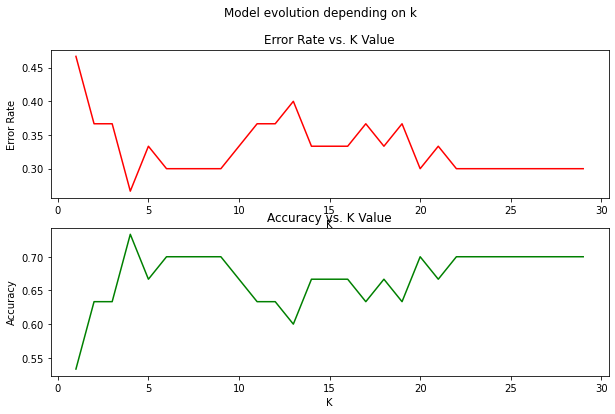

In [12]:
error_rate_knn = []
accuracy_knn = []

for i in range(1,30):

    # kNN
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)

    error_rate_knn.append(np.mean(y_pred != y_test))
    accuracy_knn.append(metrics.accuracy_score(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
fig.suptitle('Model evolution depending on k')

ax1.plot(range(1,30),error_rate_knn,color='red')
ax1.set_title('Error Rate vs. K Value')
ax1.set_xlabel('K')
ax1.set_ylabel('Error Rate')

ax2.plot(range(1,30),accuracy_knn,color='green')
ax2.set_title('Accuracy vs. K Value')
ax2.set_xlabel('K')
ax2.set_ylabel('Accuracy')

plt.show()

##### KMeans

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2, random_state=0) #random_state=i
kmeans.fit(X_train, y_train)
y_pred = kmeans.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

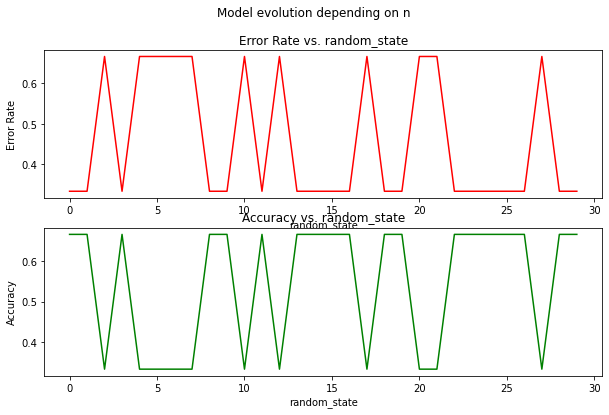

In [178]:
error_rate = []
accuracy = []

for i in range(0,30):

    kmeans = KMeans(n_clusters=2, random_state=i)
    kmeans.fit(X_train, y_train)
    y_pred = kmeans.predict(X_test)

    error_rate.append(np.mean(y_pred != y_test))
    accuracy.append(metrics.accuracy_score(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
fig.suptitle('Model evolution depending on n')

ax1.plot(range(0,30),error_rate,color='red')
ax1.set_title('Error Rate vs. random_state')
ax1.set_xlabel('random_state')
ax1.set_ylabel('Error Rate')

ax2.plot(range(0,30),accuracy,color='green')
ax2.set_title('Accuracy vs. random_state')
ax2.set_xlabel('random_state')
ax2.set_ylabel('Accuracy')

plt.show()